### Import

In [163]:
import os
import sys
import numpy as np
import pandas as pd
import imageio
import pickle
import time
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import visualkeras
from matplotlib import cm
from mpl_toolkits import mplot3d
from tensorflow.keras import datasets, layers, models
from tqdm import tqdm
from PIL import Image
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Reshape, Dense, Flatten
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses

### Fonts

In [2]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}

### Read MINST

In [3]:
(Xtrain, ytrain), (Xtest, ytest) = tf.keras.datasets.mnist.load_data()

### Resize the MNIST data to match the CIFAR10

In [4]:
Xtrain_resized = []
Xtest_resized = []
imresized = np.zeros((32,32,1))
for i in range(Xtrain.shape[0]):
    imarray = Xtrain[i,:,:]
    im = Image.fromarray(imarray)
    im = im.resize((32,32))
    imresized[:,:,0] = np.array(im)
    imresized = imresized - np.min(imresized)
    imresized = imresized / np.max(imresized)
    Xtrain_resized.append(imresized)
for i in range(Xtest.shape[0]):
    imarray = Xtest[i,:,:]
    im = Image.fromarray(imarray)
    im = im.resize((32,32))
    imresized[:,:,0] = np.array(im)
    imresized = imresized - np.min(imresized)
    imresized = imresized / np.max(imresized)
    Xtest_resized.append(imresized)
Xtest = np.array(Xtest_resized) / 255.0
Xtrain = np.array(Xtrain_resized) / 255.0
Xtrain.shape

(60000, 32, 32, 1)

### View a few examples

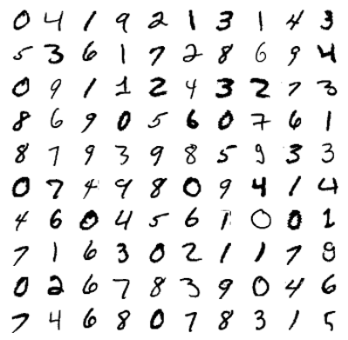

In [5]:
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    digit = Xtrain[idx,:,:,:]
    ax.imshow(digit,cmap=plt.cm.binary)
    ax.axis("off")
plt.savefig('../../assets/matplotlib/26-mnist.png', dpi=300,bbox_inches="tight")    

### Create Model

In [113]:
model = models.Sequential()
model.add(layers.Conv2D(6, 5, activation='tanh', input_shape=Xtrain.shape[1:]))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(16, 5, activation='tanh'))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(120, 5, activation='tanh'))
model.add(layers.Flatten())
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 activation_2 (Activation)   (None, 14, 14, 6)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 activation_3 (Activation)   (None, 5, 5, 16)         

### Compile Model

In [7]:
model.compile(optimizer='adam', 
              loss=losses.sparse_categorical_crossentropy, 
              metrics=['accuracy'])

### Fit

In [57]:
history = model.fit(Xtrain, ytrain, 
                    batch_size=64, epochs=10, verbose=0,
                    validation_data=(Xtest, ytest))

### Load Test Input Image

In [85]:
im = Image.open('../../data/test_images/jari_32x32.png');
im = np.array(im)
alphaim = np.ones((im.shape[0],im.shape[1],4))
alphaim[:,:,:3] = im
alphaim = alphaim / 255.0
alphaim = np.flipud(alphaim)

### Create Animation - LeNet Convolution Layer 1

In [179]:
lwidth = 1.0
dim0 = 33
dim1 = 29
count = 0
C0 = np.random.random((dim0,dim0,4))
F0 = np.random.random((dim0,dim0))
aval0 = np.linspace(-2,2, dim0)
bval0 = np.linspace(-2,2, dim0)
[am0,bm0] = np.meshgrid(aval0, bval0)
Z0 = np.zeros((dim0,dim0))
C1 = np.random.random((dim1,dim1,4))
C1[:,:,1] = C1[:,:,0]
C1[:,:,2] = C1[:,:,0]
F1 = np.random.random((dim1,dim1))
aval1 = np.linspace(-1.5,1.5, dim1)
bval1 = np.linspace(-1.5,1.5, dim1)
[am1,bm1] = np.meshgrid(aval1, bval1)
Z1 = np.zeros((dim1,dim1)) + 3
fig = plt.figure(figsize=(8, 8))

#Loop
for i in range(10,18):
    for j in range(10,18):
        ax = fig.add_subplot(111, projection='3d',computed_zorder=False )
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
        h = ax.plot_surface(am0, bm0, Z0, alpha=1, rstride=1, cstride=1, 
                    antialiased = True,facecolors=alphaim, shade=False)
        surf = ax.plot_surface(am0, bm0, Z0, rstride=1, cstride=1, antialiased = True,
                       linewidth=0.5,edgecolor='w', shade=False)
        surf.set_facecolor((0,0,0,0))
        h = ax.plot_surface(am1, bm1, Z1, 
                    alpha=1, rstride=1, cstride=1, 
                    antialiased = True, facecolors=C1, shade=False,zorder=1001)
        surf = ax.plot_surface(am1, bm1, Z1, 
                       rstride=1, cstride=1, 
                       antialiased = True,linewidth=0.5,
                       edgecolor='w', facecolor=((0,0,0,0)),shade=False)
        surf.set_facecolor((0,0,0,0))

        x01 = am0[i,j]
        x02 = am0[i+5,j]
        x03 = am0[i+5,j+5]
        x04 = am0[i,j+5]
        y01 = bm0[i,j]
        y02 = bm0[i+5,j]
        y03 = bm0[i+5,j+5]
        y04 = bm0[i,j+5]
        ax.plot([x01,x02],[y01,y02],[0,0],'r',linewidth=lwidth)
        ax.plot([x02,x03],[y02,y03],[0,0],'r',linewidth=lwidth)
        ax.plot([x03,x04],[y03,y04],[0,0],'r',linewidth=lwidth)
        ax.plot([x04,x01],[y04,y01],[0,0],'r',linewidth=lwidth)

        x11 = am1[i,j]
        x12 = am1[i+1,j]
        x13 = am1[i+1,j+1]
        x14 = am1[i,j+1]
        y11 = bm1[i,j]
        y12 = bm1[i+1,j]
        y13 = bm1[i+1,j+1]
        y14 = bm1[i,j+1]
        ax.plot([x11,x12],[y11,y12],[3.01,3.01],'r',linewidth=lwidth,zorder=2000)
        ax.plot([x12,x13],[y12,y13],[3.01,3.01],'r',linewidth=lwidth,zorder=2000)
        ax.plot([x13,x14],[y13,y14],[3.01,3.01],'r',linewidth=lwidth,zorder=2000)
        ax.plot([x14,x11],[y14,y11],[3.01,3.01],'r',linewidth=lwidth,zorder=2000)
        ax.plot([x01,x11],[y01,y11],[0,3],'r',linewidth=lwidth)
        ax.plot([x02,x12],[y02,y12],[0,3],'r',linewidth=lwidth)
        ax.plot([x03,x13],[y03,y13],[0,3],'r',linewidth=lwidth)
        ax.plot([x04,x14],[y04,y14],[0,3],'r',linewidth=lwidth)
        
        xlm = ax.get_xlim3d()
        ylm = ax.get_ylim3d()
        zlm = ax.get_zlim3d()
        ax.set_xlim3d(-3,3)
        ax.set_ylim3d(-3,3)
        ax.set_zlim3d(0,5)
        plt.axis('off');

        plt.savefig('../../assets/gifs/lenet_conv0_' + str(count) + '.png', dpi=200,bbox_inches="tight")
        time.sleep(1.0)
        count = count + 1
        plt.clf();

<Figure size 576x576 with 0 Axes>

### Create Animation - LeNet Convolution Layer 2

In [184]:
lwidth = 1.0
dim0 = 15
dim1 = 11
count = 0
C0 = np.random.random((dim0,dim0,4))
C0[:,:,1] = C0[:,:,0]
C0[:,:,2] = C0[:,:,0]
F0 = np.random.random((dim0,dim0))
aval0 = np.linspace(-2,2, dim0)
bval0 = np.linspace(-2,2, dim0)
[am0,bm0] = np.meshgrid(aval0, bval0)
Z0 = np.zeros((dim0,dim0))
C1 = np.random.random((dim1,dim1,4))
C1[:,:,1] = C1[:,:,0]
C1[:,:,2] = C1[:,:,0]
F1 = np.random.random((dim1,dim1))
aval1 = np.linspace(-1.5,1.5, dim1)
bval1 = np.linspace(-1.5,1.5, dim1)
[am1,bm1] = np.meshgrid(aval1, bval1)
Z1 = np.zeros((dim1,dim1)) + 3
fig = plt.figure(figsize=(8, 8))

#Loop
for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(111, projection='3d',computed_zorder=False )
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
        h = ax.plot_surface(am0, bm0, Z0, alpha=1, rstride=1, cstride=1, 
                    antialiased = True,facecolors=C0, shade=False)
        surf = ax.plot_surface(am0, bm0, Z0, rstride=1, cstride=1, antialiased = True,
                       linewidth=0.5,edgecolor='w', shade=False)
        surf.set_facecolor((0,0,0,0))
        h = ax.plot_surface(am1, bm1, Z1, 
                    alpha=1, rstride=1, cstride=1, 
                    antialiased = True, facecolors=C1, shade=False,zorder=1001)
        surf = ax.plot_surface(am1, bm1, Z1, 
                       rstride=1, cstride=1, 
                       antialiased = True,linewidth=0.5,
                       edgecolor='w', facecolor=((0,0,0,0)),shade=False)
        surf.set_facecolor((0,0,0,0))

        x01 = am0[i,j]
        x02 = am0[i+5,j]
        x03 = am0[i+5,j+5]
        x04 = am0[i,j+5]
        y01 = bm0[i,j]
        y02 = bm0[i+5,j]
        y03 = bm0[i+5,j+5]
        y04 = bm0[i,j+5]
        ax.plot([x01,x02],[y01,y02],[0,0],'r',linewidth=lwidth)
        ax.plot([x02,x03],[y02,y03],[0,0],'r',linewidth=lwidth)
        ax.plot([x03,x04],[y03,y04],[0,0],'r',linewidth=lwidth)
        ax.plot([x04,x01],[y04,y01],[0,0],'r',linewidth=lwidth)

        x11 = am1[i,j]
        x12 = am1[i+1,j]
        x13 = am1[i+1,j+1]
        x14 = am1[i,j+1]
        y11 = bm1[i,j]
        y12 = bm1[i+1,j]
        y13 = bm1[i+1,j+1]
        y14 = bm1[i,j+1]
        ax.plot([x11,x12],[y11,y12],[3.01,3.01],'r',linewidth=lwidth,zorder=2000)
        ax.plot([x12,x13],[y12,y13],[3.01,3.01],'r',linewidth=lwidth,zorder=2000)
        ax.plot([x13,x14],[y13,y14],[3.01,3.01],'r',linewidth=lwidth,zorder=2000)
        ax.plot([x14,x11],[y14,y11],[3.01,3.01],'r',linewidth=lwidth,zorder=2000)
        ax.plot([x01,x11],[y01,y11],[0,3],'r',linewidth=lwidth)
        ax.plot([x02,x12],[y02,y12],[0,3],'r',linewidth=lwidth)
        ax.plot([x03,x13],[y03,y13],[0,3],'r',linewidth=lwidth)
        ax.plot([x04,x14],[y04,y14],[0,3],'r',linewidth=lwidth)
        
        xlm = ax.get_xlim3d()
        ylm = ax.get_ylim3d()
        zlm = ax.get_zlim3d()
        ax.set_xlim3d(-3,3)
        ax.set_ylim3d(-3,3)
        ax.set_zlim3d(0,5)
        plt.axis('off');

        plt.savefig('../../assets/gifs/lenet_conv2_' + str(count) + '.png', dpi=200,bbox_inches="tight")
        count = count + 1
        plt.clf();

<Figure size 576x576 with 0 Axes>

### Create MaxPooling Animation - Layer 1

In [193]:
lwidth = 1.0
dim0 = 29
dim1 = 15
count = 0
C0 = np.random.random((dim0,dim0,4))
C0[:,:,1] = C0[:,:,0]
C0[:,:,2] = C0[:,:,0]
F0 = np.random.random((dim0,dim0))
aval0 = np.linspace(-2,2, dim0)
bval0 = np.linspace(-2,2, dim0)
[am0,bm0] = np.meshgrid(aval0, bval0)
Z0 = np.zeros((dim0,dim0))
C1 = np.random.random((dim1,dim1,4))
C1[:,:,1] = C1[:,:,0]
C1[:,:,2] = C1[:,:,0]
F1 = np.random.random((dim1,dim1))
aval1 = np.linspace(-1.5,1.5, dim1)
bval1 = np.linspace(-1.5,1.5, dim1)
[am1,bm1] = np.meshgrid(aval1, bval1)
Z1 = np.zeros((dim1,dim1)) + 3
fig = plt.figure(figsize=(8, 8))

#Loop
mi = 0
mj = 0
for i in range(0,28,2):
    mj = 0
    for j in range(0,28,2):
        ax = fig.add_subplot(111, projection='3d',computed_zorder=False )
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
        h = ax.plot_surface(am0, bm0, Z0, alpha=1, rstride=1, cstride=1, 
                    antialiased = True,facecolors=C0, shade=False)
        surf = ax.plot_surface(am0, bm0, Z0, rstride=1, cstride=1, antialiased = True,
                       linewidth=0.5,edgecolor='w', shade=False)
        surf.set_facecolor((0,0,0,0))
        h = ax.plot_surface(am1, bm1, Z1, 
                    alpha=1, rstride=1, cstride=1, 
                    antialiased = True, facecolors=C1, shade=False,zorder=1001)
        surf = ax.plot_surface(am1, bm1, Z1, 
                       rstride=1, cstride=1, 
                       antialiased = True,linewidth=0.5,
                       edgecolor='w', facecolor=((0,0,0,0)),shade=False)
        surf.set_facecolor((0,0,0,0))

        x01 = am0[i,j]
        x02 = am0[i+2,j]
        x03 = am0[i+2,j+2]
        x04 = am0[i,j+2]
        y01 = bm0[i,j]
        y02 = bm0[i+2,j]
        y03 = bm0[i+2,j+2]
        y04 = bm0[i,j+2]
        ax.plot([x01,x02],[y01,y02],[0,0],'r',linewidth=lwidth)
        ax.plot([x02,x03],[y02,y03],[0,0],'r',linewidth=lwidth)
        ax.plot([x03,x04],[y03,y04],[0,0],'r',linewidth=lwidth)
        ax.plot([x04,x01],[y04,y01],[0,0],'r',linewidth=lwidth)

        x11 = am1[mi,mj]
        x12 = am1[mi+1,mj]
        x13 = am1[mi+1,mj+1]
        x14 = am1[mi,mj+1]
        y11 = bm1[mi,mj]
        y12 = bm1[mi+1,mj]
        y13 = bm1[mi+1,mj+1]
        y14 = bm1[mi,mj+1]
        ax.plot([x11,x12],[y11,y12],[3.01,3.01],'r',linewidth=lwidth,zorder=2000)
        ax.plot([x12,x13],[y12,y13],[3.01,3.01],'r',linewidth=lwidth,zorder=2000)
        ax.plot([x13,x14],[y13,y14],[3.01,3.01],'r',linewidth=lwidth,zorder=2000)
        ax.plot([x14,x11],[y14,y11],[3.01,3.01],'r',linewidth=lwidth,zorder=2000)
        ax.plot([x01,x11],[y01,y11],[0,3],'r',linewidth=lwidth)
        ax.plot([x02,x12],[y02,y12],[0,3],'r',linewidth=lwidth)
        ax.plot([x03,x13],[y03,y13],[0,3],'r',linewidth=lwidth)
        ax.plot([x04,x14],[y04,y14],[0,3],'r',linewidth=lwidth)
        
        xlm = ax.get_xlim3d()
        ylm = ax.get_ylim3d()
        zlm = ax.get_zlim3d()
        ax.set_xlim3d(-3,3)
        ax.set_ylim3d(-3,3)
        ax.set_zlim3d(0,5)
        plt.axis('off');
        plt.savefig('../../assets/gifs/lenet_maxpooling1_' + str(count) + '.png', dpi=200,bbox_inches="tight")
        mj = mj + 1
        count = count + 1
        plt.clf();    
    mi = mi + 1

<Figure size 576x576 with 0 Axes>

### Create MaxPooling Animation - Layer 2

In [197]:
lwidth = 1.0
dim0 = 11
dim1 = 6
count = 0
C0 = np.random.random((dim0,dim0,4))
C0[:,:,1] = C0[:,:,0]
C0[:,:,2] = C0[:,:,0]
F0 = np.random.random((dim0,dim0))
aval0 = np.linspace(-2,2, dim0)
bval0 = np.linspace(-2,2, dim0)
[am0,bm0] = np.meshgrid(aval0, bval0)
Z0 = np.zeros((dim0,dim0))
C1 = np.random.random((dim1,dim1,4))
C1[:,:,1] = C1[:,:,0]
C1[:,:,2] = C1[:,:,0]
F1 = np.random.random((dim1,dim1))
aval1 = np.linspace(-1.5,1.5, dim1)
bval1 = np.linspace(-1.5,1.5, dim1)
[am1,bm1] = np.meshgrid(aval1, bval1)
Z1 = np.zeros((dim1,dim1)) + 3
fig = plt.figure(figsize=(8, 8))

#Loop
mi = 0
mj = 0
for i in range(0,10,2):
    mj = 0
    for j in range(0,10,2):
        ax = fig.add_subplot(111, projection='3d',computed_zorder=False )
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
        h = ax.plot_surface(am0, bm0, Z0, alpha=1, rstride=1, cstride=1, 
                    antialiased = True,facecolors=C0, shade=False)
        surf = ax.plot_surface(am0, bm0, Z0, rstride=1, cstride=1, antialiased = True,
                       linewidth=0.5,edgecolor='w', shade=False)
        surf.set_facecolor((0,0,0,0))
        h = ax.plot_surface(am1, bm1, Z1, 
                    alpha=1, rstride=1, cstride=1, 
                    antialiased = True, facecolors=C1, shade=False,zorder=1001)
        surf = ax.plot_surface(am1, bm1, Z1, 
                       rstride=1, cstride=1, 
                       antialiased = True,linewidth=0.5,
                       edgecolor='w', facecolor=((0,0,0,0)),shade=False)
        surf.set_facecolor((0,0,0,0))

        x01 = am0[i,j]
        x02 = am0[i+2,j]
        x03 = am0[i+2,j+2]
        x04 = am0[i,j+2]
        y01 = bm0[i,j]
        y02 = bm0[i+2,j]
        y03 = bm0[i+2,j+2]
        y04 = bm0[i,j+2]
        ax.plot([x01,x02],[y01,y02],[0,0],'r',linewidth=lwidth)
        ax.plot([x02,x03],[y02,y03],[0,0],'r',linewidth=lwidth)
        ax.plot([x03,x04],[y03,y04],[0,0],'r',linewidth=lwidth)
        ax.plot([x04,x01],[y04,y01],[0,0],'r',linewidth=lwidth)

        x11 = am1[mi,mj]
        x12 = am1[mi+1,mj]
        x13 = am1[mi+1,mj+1]
        x14 = am1[mi,mj+1]
        y11 = bm1[mi,mj]
        y12 = bm1[mi+1,mj]
        y13 = bm1[mi+1,mj+1]
        y14 = bm1[mi,mj+1]
        ax.plot([x11,x12],[y11,y12],[3.01,3.01],'r',linewidth=lwidth,zorder=2000)
        ax.plot([x12,x13],[y12,y13],[3.01,3.01],'r',linewidth=lwidth,zorder=2000)
        ax.plot([x13,x14],[y13,y14],[3.01,3.01],'r',linewidth=lwidth,zorder=2000)
        ax.plot([x14,x11],[y14,y11],[3.01,3.01],'r',linewidth=lwidth,zorder=2000)
        ax.plot([x01,x11],[y01,y11],[0,3],'r',linewidth=lwidth)
        ax.plot([x02,x12],[y02,y12],[0,3],'r',linewidth=lwidth)
        ax.plot([x03,x13],[y03,y13],[0,3],'r',linewidth=lwidth)
        ax.plot([x04,x14],[y04,y14],[0,3],'r',linewidth=lwidth)
        
        xlm = ax.get_xlim3d()
        ylm = ax.get_ylim3d()
        zlm = ax.get_zlim3d()
        ax.set_xlim3d(-3,3)
        ax.set_ylim3d(-3,3)
        ax.set_zlim3d(0,5)
        plt.axis('off');
        plt.savefig('../../assets/gifs/lenet_maxpooling2_' + str(count) + '.png', dpi=200,bbox_inches="tight")
        mj = mj + 1
        count = count + 1
        plt.clf();    
    mi = mi + 1

<Figure size 576x576 with 0 Axes>